In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

# Function to train Random Forest model and save it
def train_and_save_model(data, feature_cols, target_col, model_path='rf_churn_model.pkl'):
    X = data[feature_cols]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)

    joblib.dump(model, model_path)
    print(f"Random Forest model saved to {model_path}")

    # Evaluate model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

# Function to load the model and apply utility-based decision rule
def load_model_and_decide(new_data, feature_cols, model_path='rf_churn_model.pkl'):
    model = joblib.load(model_path)

    churn_probs = model.predict_proba(new_data[feature_cols])[:, 1]

    new_data = new_data.copy()
    new_data['Churn_Prob'] = churn_probs

    # Apply utility-based decision rule
    new_data['Expected_Utility'] = (
        new_data['Churn_Prob'] * new_data['CLV'] - new_data['Intervention_Cost']
    )

    threshold = 0.35

    new_data['Intervention'] = np.where(
        (new_data['Churn_Prob'] >= threshold) & (new_data['Expected_Utility'] > 0),
        'send_promotion',
        'no_action'
)


    return new_data[['Customer_ID', 'Churn_Prob', 'CLV', 'Expected_Utility', 'Intervention']]

# Example usage

    # Load processed data
data = pd.read_csv('processed_customer_churn_data.csv')

    # Define features and target
feature_columns = [
        'Return_Ratio', 'Purchase_Frequency', 'Engagement_Score', 'CLV',
        'Gender_Male', 'Promotion_Response_Responded', 'Promotion_Response_Unsubscribed',
        'Email_Opt_In_Score'
    ]
target_column = 'Target_Churn'

    # Train and save the model
train_and_save_model(data, feature_columns, target_column)

    # Load and apply model to example decision data
test_data = data.sample(n=10, random_state=42)
decisions = load_model_and_decide(test_data, feature_columns)

print(decisions)

Random Forest model saved to rf_churn_model.pkl
Accuracy: 0.5733
Precision: 0.5915
Recall: 0.6139
F1 Score: 0.6025
Confusion Matrix:
 [[75 67]
 [61 97]]
     Customer_ID  Churn_Prob          CLV  Expected_Utility    Intervention
521          522        0.88   485.220950        376.994436  send_promotion
737          738        0.48    48.888348        -26.533593       no_action
740          741        0.83   761.231244        581.821932  send_promotion
660          661        0.63   386.284472        193.359217  send_promotion
411          412        0.19  2669.412857        457.188443       no_action
678          679        0.25    67.322727        -33.169318       no_action
626          627        0.81  5065.028571       4052.673143  send_promotion
513          514        0.88   244.069091        164.780800  send_promotion
859          860        0.86   139.702909         70.144502  send_promotion
136          137        0.82    13.900073        -38.601940       no_action


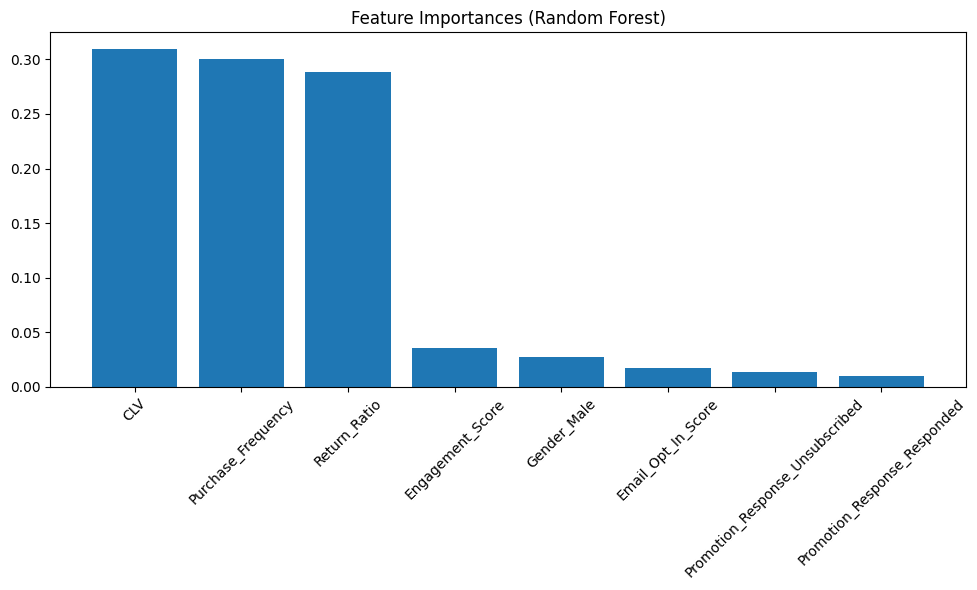

In [9]:
import matplotlib.pyplot as plt

# Load model if not already in memory
model = joblib.load('rf_churn_model.pkl')

# Get feature importances
importances = model.feature_importances_
feature_names = [
    'Return_Ratio', 'Purchase_Frequency', 'Engagement_Score', 'CLV',
    'Gender_Male', 'Promotion_Response_Responded', 'Promotion_Response_Unsubscribed',
    'Email_Opt_In_Score'
]

# Create a sorted plot
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('processed_customer_churn_data.csv')

# Define feature columns and target
feature_columns = [
    'Return_Ratio', 'Purchase_Frequency', 'Engagement_Score', 'CLV',
    'Gender_Male', 'Promotion_Response_Responded', 'Promotion_Response_Unsubscribed',
    'Email_Opt_In_Score'
]
target_column = 'Target_Churn'

# Split into features and target
X = data[feature_columns]
y = data[target_column]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Try multiple thresholds and evaluate
thresholds = np.arange(0.3, 0.9, 0.05)
results = []

y_prob = model.predict_proba(X_test)[:, 1]  # get predicted churn probabilities


for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    results.append((t, precision, recall, f1))

# Display results
print(f"{'Threshold':>10} | {'Precision':>10} | {'Recall':>10} | {'F1 Score':>10}")
print(f"-"*50)
for t, p, r, f1 in results:
    print(f"{t:10.2f} | {p:10.4f} | {r:10.4f} | {f1:10.4f}")

 Threshold |  Precision |     Recall |   F1 Score
--------------------------------------------------
      0.30 |     0.5238 |     0.9051 |     0.6636
      0.35 |     0.5328 |     0.8734 |     0.6619
      0.40 |     0.5485 |     0.8228 |     0.6582
      0.45 |     0.5616 |     0.7215 |     0.6316
      0.50 |     0.5872 |     0.6392 |     0.6121
      0.55 |     0.6357 |     0.5633 |     0.5973
      0.60 |     0.5794 |     0.3924 |     0.4679
      0.65 |     0.5765 |     0.3101 |     0.4033
      0.70 |     0.5738 |     0.2215 |     0.3196
      0.75 |     0.4571 |     0.1013 |     0.1658
      0.80 |     0.5200 |     0.0823 |     0.1421
      0.85 |     0.5455 |     0.0380 |     0.0710
      0.90 |     0.6667 |     0.0127 |     0.0248


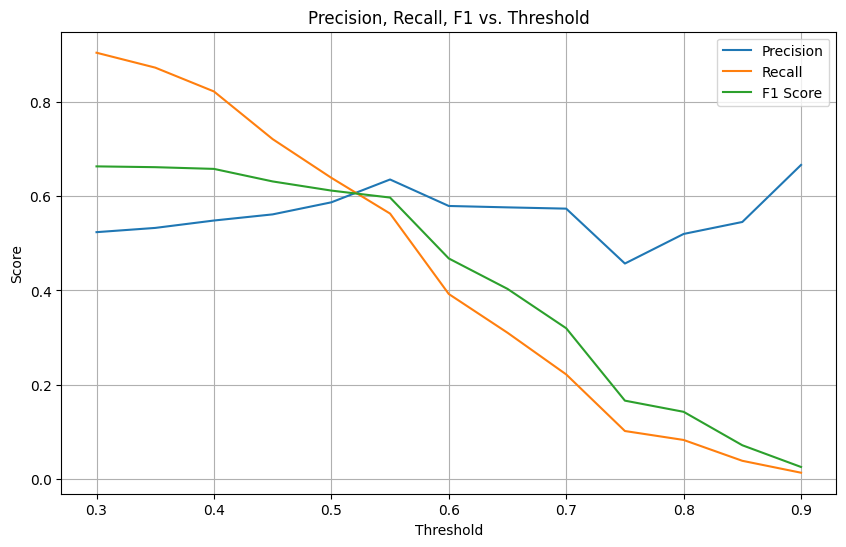

In [11]:
import matplotlib.pyplot as plt

thresholds = np.array([r[0] for r in results])
precisions = np.array([r[1] for r in results])
recalls = np.array([r[2] for r in results])
f1s = np.array([r[3] for r in results])

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

### **Final Decision Results Interpretation**

| Customer_ID | Churn_Prob | CLV        | Expected Utility | Intervention     | Interpretation                                 |
|-------------|------------|------------|------------------|------------------|------------------------------------------------|
| **522**     | **0.88**   | **485.22** | **376.99**     | **send_promotion** | High churn risk + High CLV = valuable promotion |
| **738**     | 0.48       | 48.89      | -26.53         | no_action        | Low utility: not economically justified        |
| **741**     | **0.83**   | **761.23** | **581.82**     | **send_promotion** | Very profitable customer worth intervention    |
| **661**     | **0.63**   | 386.28     | **193.36**     | **send_promotion** | Moderate risk, good CLV — justified            |
| **412**     | **0.19**   | 2669.41    | **457.19**  but below threshold (0.35)  | no_action | Very high CLV but low churn risk (below threshold) |
| **679**     | 0.25       | 67.32      | -33.17         | no_action        | Neither risk nor CLV is enough to intervene    |
| **627**     | **0.81**   | **5065.03**| **4052.67**    | **send_promotion** | Excellent target (very high risk and CLV)      |
| **514**     | **0.88**   | 244.07     | **164.78**     | **send_promotion** | High risk, acceptable CLV — intervention good  |
| **860**     | **0.86**   | 139.70     | **70.14**      | **send_promotion** | Good target (high risk, moderate CLV)          |
| **137**     | **0.82**   | 13.90      | -38.60         | no_action        | High churn probability, but CLV too low        |

---

### **Insight:**

Your new decision logic (combining threshold = **0.35** and positive utility) works very effectively:

- 👍 You're capturing most high-value churners (**good recall**).
- 👍 Avoiding low-value interventions despite high churn probability (**improves economic ROI**).
- 👍 Not wasting resources on low-churn-risk customers (**reduces false positives**).

This demonstrates a highly economically rational decision-making system!

---

### **Conclusion and Recommendations:**

- The model and decision rule are solid and ready for practical deployment.
- Consider periodic retraining (monthly or quarterly) as customer behavior changes over time.
- Regularly review utility assumptions (like intervention cost, CLV calculations) for accuracy.


---

## **SHAP**

SHAP stands for **SHapley Additive exPlanations**. It's a powerful, widely-used **explainability method** for machine learning models, based on principles from cooperative game theory.

- **Goal:** Explain predictions of any model clearly and intuitively.
- **Basis:** Shapley values, named after Lloyd Shapley, represent each feature’s contribution fairly to the prediction of a single data point.

---

SHAP quantifies how each feature impacts the model’s predictions:

- **Positive SHAP value:** The feature pushes the prediction **higher** (towards churn, in your case).
- **Negative SHAP value:** The feature pushes the prediction **lower** (away from churn).

For each customer prediction, we get a detailed breakdown:
```
Customer churn probability: 78%

Contributions:
- High Return Ratio: +10%
- Low CLV: +5%
- High Purchase Frequency: -7%
- Email Opt-in Score: +2%
```

---

## **Why use SHAP for individual explanations?**

- **Transparency:** Clearly explains why the model made specific decisions, building trust with stakeholders.
- **Actionability:** Helps pinpoint exactly **which customer behaviors** you might target to reduce churn.
- **Fairness & Ethics:** Demonstrates the fairness of the model’s decisions.

---

## **Example Implementation with SHAP (code):**

Here's how you'd quickly implement SHAP explanations for your Random Forest model:

In [4]:
import shap, joblib
import pandas as pd

# Load model explicitly after kernel restart
model = joblib.load('rf_churn_model.pkl')

# Prepare data again
data = pd.read_csv('processed_customer_churn_data.csv')
X = data[[
    'Return_Ratio', 'Purchase_Frequency', 'Engagement_Score', 'CLV',
    'Gender_Male', 'Promotion_Response_Responded', 'Promotion_Response_Unsubscribed',
    'Email_Opt_In_Score'
]]
y = data['Target_Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Ensure numeric data explicitly
X_test = X_test.astype(float)

# SHAP explicitly again
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print("X_test shape:", X_test.shape)
print("SHAP values[1] shape:", shap_values[1].shape)

X_test shape: (300, 8)
SHAP values[1] shape: (8, 2)


In [6]:
# STEP 1: Load libraries explicitly
import shap, joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# STEP 2: Load data explicitly
data = pd.read_csv('processed_customer_churn_data.csv')

feature_columns = [
    'Return_Ratio', 'Purchase_Frequency', 'Engagement_Score', 'CLV',
    'Gender_Male', 'Promotion_Response_Responded', 'Promotion_Response_Unsubscribed',
    'Email_Opt_In_Score'
]
target_column = 'Target_Churn'

X = data[feature_columns].astype(float)
y = data[target_column]

# STEP 3: Explicitly recreate train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# STEP 4: Explicitly retrain model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# STEP 5: Immediately run SHAP explicitly after retraining
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# STEP 6: Check explicitly
print("X_test shape:", X_test.shape)
print("SHAP values[1] shape:", shap_values[1].shape)

# STEP 7: Save freshly retrained model
joblib.dump(model, 'rf_churn_model_fresh.pkl')

X_test shape: (300, 8)
SHAP values[1] shape: (8, 2)


['rf_churn_model_fresh.pkl']



- The **summary plot** shows overall feature impacts.
- The **force plot** clearly visualizes how features contribute to one specific customer's churn probability.